In [89]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import seaborn as sns
import datetime
import sklearn
from sklearn.model_selection import StratifiedKFold,KFold
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
import glob
from datetime import datetime
from datetime import timedelta

In [121]:
def basic_horizontal_barplot(values,labels,xaxis_label,title,xlim=None,figsize=None):
    """
    Please provide the labels corresponding to the values, the plot title, and the xaxis label.
    """
    # Possible colors to use - if not enough, colors are reused
    cs=["coral","tomato","peachpuff","orange","gold","firebrick","peru","khaki","chocolate"]
    cs=cs*(len(values)//len(cs)+1)
    # The figure
    if figsize==None:
        fig=plt.figure(figsize=(4,3))
    else:
        fig=plt.figure(figsize=figsize,dpi=100)
    ax = fig.add_axes([0,0,1,0.9])
    color=cs[:len(values)]
    ax.barh(range(len(values)),values,color=color)
    ax.set_yticks(range(len(values)))
    ax.set_yticklabels(labels)
    if xlim!=None:
        ax.set_xlim(xlim)
    plt.suptitle(title)
    ax.set_xlabel(xaxis_label)
    plt.show()

    
def profitComputation(percentage_matchs,conf,model_name="0"):
    """
    Given a confidence dataset and a percentage of matches, computes the ROI 
    if we bet only on the percentage of matches we have the most confidence in
    (same amount for each match).
    """
    coeff=percentage_matchs/100
    lim=int(coeff*len(conf))
    conf=conf.sort_values("confidence"+model_name,ascending=False)
    conf=conf.iloc[:lim,:]
    profit=100*(conf.PSW[conf["win"+model_name]==1].sum()-len(conf))/len(conf)
    return profit


def plotProfits(conf,title=""):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,conf)
        profits.append(p)
    fig=plt.figure(figsize=(7,4),dpi=100)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)
    plt.show()


############################### CATEGORICAL FEATURES ENCODING ##################

### The features "player1", "player2" and "Tournament" are treated differently
### from the other features. 

def categorical_features_encoding(cat_features):
    """
    Categorical features encoding.
    Simple one-hot encoding.
    """
    cat_features=cat_features.apply(preprocessing.LabelEncoder().fit_transform)
    ohe=OneHotEncoder()
    cat_features=ohe.fit_transform(cat_features)
    cat_features=pd.DataFrame(cat_features.todense())
    cat_features.columns=["cat_feature_"+str(i) for i in range(len(cat_features.columns))]
    cat_features=cat_features.astype(int)
    return cat_features

def features_players_encoding(data):
    """
    Encoding of the players . 
    The players are not encoded like the other categorical features because for each
    match we encode both players at the same time (we put a 1 in each row corresponding 
    to the players playing the match for each match).
    """
    winners=data.Winner
    losers=data.Loser
    le = preprocessing.LabelEncoder()
    le.fit(list(winners)+list(losers))
    winners=le.transform(winners)
    losers=le.transform(losers)
    encod=np.zeros([len(winners),len(le.classes_)])
    for i in range(len(winners)):
        encod[i,winners[i]]+=1
    for i in range(len(losers)):
        encod[i,losers[i]]+=1
    columns=["player_"+el for el in le.classes_]
    players_encoded=pd.DataFrame(encod,columns=columns)
    return players_encoded

def features_tournaments_encoding(data):
    """
    Encoding of the tournaments . 
    """
    tournaments=data.Tournament
    le = preprocessing.LabelEncoder()
    tournaments=le.fit_transform(tournaments)
    encod=np.zeros([len(tournaments),len(le.classes_)])
    for i in range(len(tournaments)):
        encod[i,tournaments[i]]+=1
    columns=["tournament_"+el for el in le.classes_]
    tournaments_encoded=pd.DataFrame(encod,columns=columns)
    return tournaments_encoded


def compute_elo_rankings(data):
    """
    Given the list on matches in chronological order, for each match, computes 
    the elo ranking of the 2 players at the beginning of the match
    
    """
    print("Elo rankings computing...")
    players=list(pd.Series(list(data.Winner)+list(data.Loser)).value_counts().index)
    elo=pd.Series(np.ones(len(players))*1500,index=players)
    ranking_elo=[(1500,1500)]
    for i in range(1,len(data)):
        w=data.iloc[i-1,:].Winner
        l=data.iloc[i-1,:].Loser
        elow=elo[w]
        elol=elo[l]
        pwin=1 / (1 + 10 ** ((elol - elow) / 400))    
        K_win=32
        K_los=32
        new_elow=elow+K_win*(1-pwin)
        new_elol=elol-K_los*(1-pwin)
        elo[w]=new_elow
        elo[l]=new_elol
        ranking_elo.append((elo[data.iloc[i,:].Winner],elo[data.iloc[i,:].Loser])) 
        if i%5000==0:
            print(str(i)+" matches computed...")
    ranking_elo=pd.DataFrame(ranking_elo,columns=["elo_winner","elo_loser"])    
    ranking_elo["proba_elo"]=1 / (1 + 10 ** ((ranking_elo["elo_loser"] - ranking_elo["elo_winner"]) / 400))   
    return ranking_elo


###################### FEATURES BASED ON THE PAST OF THE PLAYERS ###############

def features_past_generation(features_creation_function,
                             days,
                             feature_names_prefix,
                             data,
                             indices):
    """
    Creates features based on the past of the players. 
    Basically a for loop. Takes 1 match at a time, selects the matches that occurred during 
    its close past (usually 150 days before max) and computes some features.
    Each match will appear twice in the dataset : 1 time per outcome of the match.
    Example : 02/03/2016 Djoko-Zverev ,Djoko won
        During the 150 days before the match, Djoko won 80% of its matches and Zverev 40%.
        We encode the outcome "Djoko wins" like that : [80,40], and tell the model this outcome happened (1).
        We encode the outcome "Zverev wins" like that : [40,80], and tell the model it didn't happen (0).
    And we do that with some more features , based on the players past stats on the surface
    of the match, on the recent injuries, ...
    In the inputs of the function, "indices" contains the indices of the matches we want to encode.
    The output of the functions is twice as long as "indices".
    (these features introduce many hyperparameters to be tuned...)
    """
    matches_outcomes=[]
    for i,match_indice in enumerate(indices):
        match=data.iloc[match_indice,:]
        past_matches=data[(data.Date<match.Date)&(data.Date>=match.Date-timedelta(days=days))]
        match_features_outcome_1=features_creation_function(1,match,past_matches)
        match_features_outcome_2=features_creation_function(2,match,past_matches)
        matches_outcomes.append(match_features_outcome_1)
        matches_outcomes.append(match_features_outcome_2)
        if i%100==0:
            print(str(i)+"/"+str(len(indices))+" matches treated.")
    train=pd.DataFrame(matches_outcomes)
    train.columns=[feature_names_prefix+str(i) for i in range(len(train.columns))]
    return train


def features_player_creation(outcome,match,past_matches):
    features_player=[]
    ##### Match information extraction (according to the outcome)
    player=match.Winner if outcome==1 else match.Loser
    surface=match.Surface
    ##### General stats
    wins=past_matches[past_matches.Winner==player]    
    losses=past_matches[past_matches.Loser==player]    
    todo=pd.concat([wins,losses],0)
    features_player+=[len(wins),len(losses),len(todo)]
    per_victory=100*len(wins)/len(todo) if len(todo)>0 else np.nan
    features_player.append(per_victory)
    ##### Surface
    past_surface=past_matches[past_matches.Surface==surface]
    wins_surface=past_surface[past_surface.Winner==player]    
    losses_surface=past_surface[past_surface.Loser==player]    
    todo_surface=pd.concat([wins_surface,losses_surface],0)
    features_player+=[len(wins_surface),len(losses_surface),len(todo_surface)]
    per_victory_surface=100*len(wins_surface)/len(todo_surface) if len(todo_surface)>0 else np.nan
    features_player.append(per_victory_surface)
    return features_player

def features_recent_creation(outcome,match,past_matches):
    ##### Match information extraction (according to the outcome)
    player=match.Winner if outcome==1 else match.Loser
    date=match.Date
    ##### Last matches
    wins=past_matches[past_matches.Winner==player]    
    losses=past_matches[past_matches.Loser==player]    
    todo=pd.concat([wins,losses],0)
    if len(todo)==0:
        return [np.nan]*7
    # Days since last match
    dslm=(date-todo.iloc[-1,:].Date).days
    # Was the last match won ?
    wlmw=int(todo.iloc[-1,:].Winner==player)
    # Ranking of the last player played
    rlpp=todo.iloc[-1,:].WRank
    # Number of sets of last match played
    nslmp=todo.iloc[-1,:]['Best of']
    # Number of sets won during last match played
    nswlmp=todo.iloc[-1,:]['Wsets'] if wlmw==1 else todo.iloc[-1,:]['Lsets']
    # Injuries - iitp + injury last match
    if len(losses)!=0:
        ilm=int(losses.iloc[-1,:].Comment=="Completed")
        iitp=1 if (losses.Comment!="Completed").sum()>0 else 0
    else:
        ilm=np.nan
        iitp=np.nan
    features_recent=[dslm,wlmw,rlpp,nslmp,nswlmp,ilm,iitp]
    return features_recent

def features_duo_creation(outcome,match,past):
    features_duo=[]
    ##### Match information extraction (according to the outcome)
    player1=match.Winner if outcome==1 else match.Loser
    player2=match.Loser if outcome==1 else match.Winner
    ##### General duo features
    # % of the previous matches between these 2 players won by each.
    duo1=past[(past.Winner==player1)&(past.Loser==player2)]    
    duo2=past[(past.Winner==player2)&(past.Loser==player1)]    
    duo=pd.concat([duo1,duo2],0)
    features_duo+=[len(duo),len(duo1),len(duo2)]
    per_victory_player1=100*len(duo1)/len(duo) if len(duo)>0 else np.nan
    features_duo.append(per_victory_player1)
    return features_duo

def features_general_creation(outcome,match,past_matches):
    features_general=[]
    ##### Match information extraction (according to the outcome)
    player1=match.Winner if outcome==1 else match.Loser
    rank_player_1=match.WRank if outcome==1 else match.LRank
    rank_player_2=match.LRank if outcome==1 else match.WRank
    
    features_general+=[rank_player_1,rank_player_2,
                       rank_player_2-rank_player_1,
                       int(rank_player_1>rank_player_2)]
    best_ranking_as_winner=past_matches[(past_matches.Winner==player1)].WRank.min()
    best_ranking_as_loser=past_matches[(past_matches.Loser==player1)].LRank.min()
    best_ranking=min(best_ranking_as_winner,best_ranking_as_loser)
    features_general.append(best_ranking)
    return features_general


############################### STRATEGY ASSESSMENT ############################
### the following functions are used to make the predictions and compute the ROI

def xgbModelBinary(xtrain,ytrain,xval,yval,p,sample_weights=None):
    """
    XGB model training. 
    Early stopping is performed using xval and yval (validation set).
    Outputs the trained model, and the prediction on the validation set
    """
    if sample_weights==None:
        dtrain=xgb.DMatrix(xtrain,label=ytrain)
    else:
        dtrain=xgb.DMatrix(xtrain,label=ytrain,weight=sample_weights)
    dval=xgb.DMatrix(xval,label=yval)
    eval_set = [(dtrain,"train_loss"),(dval, 'eval')]
    params={'eval_metric':"logloss","objective":"binary:logistic",'subsample':0.8,
            'min_child_weight':p[2],'alpha':p[6],'lambda':p[5],'max_depth':int(p[1]),
            'gamma':p[3],'eta':p[0],'colsample_bytree':p[4]}
    model=xgb.train(params, dtrain, int(p[7]),evals=eval_set,early_stopping_rounds=int(p[8]))
    return model


def assessStrategyGlobal(test_beginning_match,
                         duration_train_matches,
                         duration_val_matches,
                         duration_test_matches,
                         xgb_params,
                         nb_players,
                         nb_tournaments,
                         features,
                         data,
                         model_name="0"):
    """
    Given the id of the first match of the testing set (id=index in the dataframe "data"),
    outputs the confidence dataframe.
    The confidence dataframe tells for each match is our prediction is right, and for
    the outcome we chose, the confidence level.
    The confidence level is simply the probability we predicted divided by the probability
    implied by the bookmaker (=1/odd).
    """
    ########## Training/validation/testing set generation
    
    # Number of matches in our dataset (ie. nb. of outcomes divided by 2)
    nm=int(len(features)/2)
    
    # Id of the first and last match of the testing,validation,training set
    beg_test=test_beginning_match
    end_test=min(test_beginning_match+duration_test_matches-1,nm-1)
    end_val=min(beg_test-1,nm-1)
    beg_val=beg_test-duration_val_matches
    end_train=beg_val-1
    beg_train=beg_val-duration_train_matches
       
    train_indices=range(2*beg_train,2*end_train+2)
    val_indices=range(2*beg_val,2*end_val+2)
    test_indices=range(2*beg_test,2*end_test+2)
    
    if (len(test_indices)==0)|(len(train_indices)==0):
        return 0
    
    # Split in train/validation/test
    xval=features.iloc[val_indices,:].reset_index(drop=True)
    xtest=features.iloc[test_indices,:].reset_index(drop=True)
    xtrain=features.iloc[train_indices,:].reset_index(drop=True)
    ytrain=pd.Series([1,0]*int(len(train_indices)/2))
    yval=pd.Series([1,0]*int(len(val_indices)/2))
    
    # We limit the number of players and tournaments one-hot encoded : we'll keep only the 
    # players that won the most matches to avoid overfitting and make the process quicker
    # Biggest players :
    biggest_players=data.iloc[range(beg_train,end_train),:][["Winner","Loser"]]
    biggest_players=pd.concat([biggest_players.Winner,biggest_players.Loser],0)
    biggest_players=list(biggest_players.value_counts().index[:nb_players])
    player_columns=[el for el in xtrain.columns if el[:6]=="player"]
    to_drop_players=[el for el in player_columns if el[7:] not in biggest_players]
    # Biggest Tournaments
    biggest_tournaments=data.iloc[range(beg_train,end_train),:]["Tournament"]
    biggest_tournaments=list(biggest_tournaments.value_counts().index[:nb_tournaments])
    tournament_columns=[el for el in xtrain.columns if el[:10]=="tournament"]
    to_drop_tournaments=[el for el in tournament_columns if el[11:] not in biggest_tournaments]
    # We drop smallest Tournaments and players
    xtrain=xtrain.drop(to_drop_players+to_drop_tournaments,1)
    xval=xval.drop(to_drop_players+to_drop_tournaments,1)
    xtest=xtest.drop(to_drop_players+to_drop_tournaments,1)
    
    ### ML model training
    model=xgbModelBinary(xtrain,ytrain,xval,yval,xgb_params,sample_weights=None)
    
    # The probability given by the model to each outcome of each match :
    pred_test= model.predict(xgb.DMatrix(xtest,label=None)) 
    # For each match, the winning probability the model gave to the players that won (should be high...) :
    prediction_test_winner=pred_test[range(0,len(pred_test),2)]
    # For each match, the winning probability the model gave to the players that lost (should be low...) :
    prediction_test_loser=pred_test[range(1,len(pred_test),2)]
    
    ### Odds and predicted probabilities for the testing set (1 row/match)
    odds=data[["PSW","PSL"]].iloc[range(beg_test,end_test+1)]
    implied_probabilities=1/odds
    p=pd.Series(list(zip(prediction_test_winner,prediction_test_loser,implied_probabilities.PSW,implied_probabilities.PSL)))

    ### For each match in the testing set, if the model predicted the right winner :
    right=(prediction_test_winner>prediction_test_loser).astype(int)
    ### For each match in the testing set, the confidence of the model in the outcome it chose
    def sel_match_confidence(x):
        if x[0]>x[1]:
            return x[0]/x[2] 
        else:
            return x[1]/x[3] 
    confidence=p.apply(lambda x:sel_match_confidence(x))
    
    ### The final confidence dataset 
    confidenceTest=pd.DataFrame({"match":range(beg_test,end_test+1),
                                 "win"+model_name:right,
                                 "confidence"+model_name:confidence,
                                 "PSW":odds.PSW.values})
    confidenceTest=confidenceTest.sort_values("confidence"+model_name,ascending=False).reset_index(drop=True)
    
    return confidenceTest, model

def vibratingAssessStrategyGlobal(km,dur_train,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data):
    """
    The ROI is very sensistive to the training set. A few more matches in the training set can 
    change it in a non-negligible way. Therefore it is preferable to run assessStrategyGlobal several times
    with slights changes in the training set lenght, and then combine the predictions.
    This is what this function does.
    More precisely we compute the confidence dataset of 7 models with slightly different training sets.
    For each match, each model has an opinion of the winner, and a confidence is its prediction.
    For each match, the final chosen outcome is the outcome chosen by the most models (majority voting)
    And the final confidence is the average of the confidences of the models that chose this outcome.
    """
    confTest1, _=assessStrategyGlobal(km,dur_train,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"1")
    confTest2, _=assessStrategyGlobal(km,dur_train-10,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"2")
    confTest3, _=assessStrategyGlobal(km,dur_train+10,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"3")
    confTest4, _=assessStrategyGlobal(km,dur_train-30,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"4")
    confTest5, _=assessStrategyGlobal(km,dur_train+30,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"5")
    confTest6, _=assessStrategyGlobal(km,dur_train-45,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"6")
    confTest7, _=assessStrategyGlobal(km,dur_train+45,duration_val_matches,delta,xgb_params,nb_players,nb_tournaments,xtrain,data,"7")
    if (type(confTest1)!=int)&(type(confTest2)!=int)&(type(confTest3)!=int)&(type(confTest4)!=int)&(type(confTest5)!=int):
        c=confTest1.merge(confTest2,on=["match","PSW"])
        c=c.merge(confTest3,on=["match","PSW"])
        c=c.merge(confTest4,on=["match","PSW"])
        c=c.merge(confTest5,on=["match","PSW"])
        c=c.merge(confTest6,on=["match","PSW"])
        c=c.merge(confTest7,on=["match","PSW"])
        c=pd.Series(list(zip(c.win1,c.win2,c.win3,c.win4,c.win5,
                             c.win6,c.win7,
                             c.confidence1,c.confidence2,c.confidence3,
                             c.confidence4,c.confidence5,
                             c.confidence6,c.confidence7)))
        c=pd.DataFrame.from_records(list(c.apply(mer)))
        conf=pd.concat([confTest1[["match","PSW"]],c],1)
        conf.columns=["match","PSW","win0","confidence0"]
    else:
        conf=0
    return conf


def mer(t):
    # If more than half the models choose the right outcome for the match, we can say
    # in real situation we would have been right. Otherwise wrong.
    # And the confidence in the chosen outcome is the mean of the confidences of the models
    # that chose this outcome.
    w=np.array([t[0],t[1],t[2],t[3],t[4],t[5],t[6]]).astype(bool)
    conf=np.array([t[7],t[8],t[9],t[10],t[11],t[12],t[13]])
    if w.sum()>=4:
        return 1,conf[w].mean()
    else:
        return 0,conf[~w].mean()

############################### PROFITS COMPUTING AND VISUALIZATION ############

def profitComputation(percentage,confidence,model_name="0"):
    """
    Input : percentage of matches we want to bet on,confidence dataset
    Output : ROI
    """
    tot_number_matches=len(confidence)
    number_matches_we_bet_on=int(tot_number_matches*(percentage/100))
    matches_selection=confidence.head(number_matches_we_bet_on)
    profit=100*(matches_selection.PSW[matches_selection["win"+model_name]==1].sum()-number_matches_we_bet_on)/number_matches_we_bet_on
    return profit

def plotProfits(confidence,title=""):
    """
    Given a confidence dataset, plots the ROI according to the percentage of matches
    we bet on. 
    """
    profits=[]
    ticks=range(5,101)
    for i in ticks:
        p=profitComputation(i,confidence)
        profits.append(p)
    plt.plot(ticks,profits)
    plt.xticks(range(0,101,5))
    plt.xlabel("% of matches we bet on")
    plt.ylabel("Return on investment (%)")
    plt.suptitle(title)
    
    
def profitsAlongTime(conf,matches_delta):
    span_matches=span_matches=conf.match.max()-conf.match.min()-1
    N=int(span_matches/matches_delta)+1
    milestones=np.array([conf.match.min()+matches_delta*i for i in range(N)])
    profits=[]
    lens=[]
    for i in range(N-1):
        beg=milestones[i]
        end=milestones[i+1]-1
        conf_sel=confconf[(conf.match>=beg)&(conf.match<=end)]
        l=len(conf_sel)
        lens.append(l)
        if l==0:
            profits.append(0)
        else:    
            p=profitComputation(100,conf_sel)
            profits.append(p)
    profits=np.array(profits)
    return profits,lens

In [33]:
#Reading data
# df_2000 = pd.read_excel("2000.xls")
# df_2001 = pd.read_excel("2001.xls")
# df_2002 = pd.read_excel("2002.xls")
# df_2003 = pd.read_excel("2003.xls")
# df_2004 = pd.read_excel("2004.xls")
# df_2005 = pd.read_excel("2005.xls")
# df_2006 = pd.read_excel("2006.xls")
# df_2007 = pd.read_excel("2007.xls")
# df_2008 = pd.read_excel("2008.xls")
# df_2009 = pd.read_excel("2009.xls")
# df_2010 = pd.read_excel("2010.xls")
# df_2011 = pd.read_excel("2011.xls")
# df_2012 = pd.read_excel("2012.xls")
# df_2013 = pd.read_excel("2013.xlsx")
# df_2014 = pd.read_excel("2014.xlsx")
# df_2015 = pd.read_excel("2015.xlsx")
# df_2016 = pd.read_excel("2016.xlsx")
# df_2017 = pd.read_excel("2017.xlsx")
# df_2018 = pd.read_excel("2018.xlsx")
# df_2019 = pd.read_excel("2019.xlsx")
# df_2020 = pd.read_excel("2020.xlsx")

In [34]:
# frames = [df_2000, df_2001, df_2002, df_2003, df_2004, df_2005, df_2006, df_2007, df_2008,
#          df_2009, df_2010, df_2011, df_2012, df_2013, df_2014, df_2015, df_2016, df_2017, 
#           df_2018, df_2019, df_2020]

useful_columns = ['ATP', 'Location', 'Tournament', 'Date', 'Series', 'Court', 'Surface', 'Round', 'Best of', 'Winner', 'Loser', 'WRank', 'LRank', 'Wsets', 'Lsets', 'Comment', 'PSW', 'PSL', 'B365W', 'B365L']

In [35]:
#Aggregate into one
data = pd.concat(frames)

/home/yuri/Ozon/OzonML/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


In [ ]:
# df_2012 = df_2012[useful_columns]
# df_2013 = df_2013[useful_columns]
# df_2014 = df_2014[useful_columns]
# df_2015 = df_2015[useful_columns]
# df_2016 = df_2016[useful_columns]
# df_2017 = df_2017[useful_columns]
# df_2018 = df_2018[useful_columns]
# df_2019 = df_2019[useful_columns]
# df_2020 = df_2020[useful_columns]

In [78]:
l = [pd.read_excel("2000.xls"),
 pd.read_excel("2001.xls"),
 pd.read_excel("2002.xls"),
 pd.read_excel("2003.xls"),
 pd.read_excel("2004.xls"),
 pd.read_excel("2005.xls"),
 pd.read_excel("2006.xls"),
 pd.read_excel("2007.xls"),
 pd.read_excel("2008.xls"),
 pd.read_excel("2009.xls"),
 pd.read_excel("2010.xls"),
 pd.read_excel("2011.xls"),
 pd.read_excel("2012.xls"),
pd.read_excel("2013.xlsx"),
pd.read_excel("2014.xlsx"),
pd.read_excel("2015.xlsx"),
pd.read_excel("2016.xlsx"),
pd.read_excel("2017.xlsx"),
pd.read_excel("2018.xlsx"),
pd.read_excel("2019.xlsx"),
pd.read_excel("2020.xlsx")]
no_b365=[i for i,d in enumerate(l) if "B365W" not in l[i].columns]
no_pi=[i for i,d in enumerate(l) if "PSW" not in l[i].columns]
for i in no_pi:
    l[i]["PSW"]=np.nan
    l[i]["PSL"]=np.nan
for i in no_b365:
    l[i]["B365W"]=np.nan
    l[i]["B365L"]=np.nan
l=[d[list(d.columns)[:13]+["Wsets","Lsets","Comment"]+["PSW","PSL","B365W","B365L"]] for d in [l[0]]+l[2:]]
data=pd.concat(l,0)

In [80]:
data=data.sort_values("Date")
data["WRank"]=data["WRank"].replace(np.nan,0)
data["WRank"]=data["WRank"].replace("NR",2000)
data["LRank"]=data["LRank"].replace(np.nan,0)
data["LRank"]=data["LRank"].replace("NR",2000)
data["WRank"]=data["WRank"].astype(int)
data["LRank"]=data["LRank"].astype(int)
data["Wsets"]=data["Wsets"].astype(float)
data["Lsets"]=data["Lsets"].replace("`1",1)
data["Lsets"]=data["Lsets"].astype(float)
data=data.reset_index(drop=True)

### Elo rankings data
# Computing of the elo ranking of each player at the beginning of each match.
elo_rankings = compute_elo_rankings(data)
data = pd.concat([data,elo_rankings],1)


Elo rankings computing...
5000 matches computed...
10000 matches computed...
15000 matches computed...
20000 matches computed...
25000 matches computed...
30000 matches computed...
35000 matches computed...
40000 matches computed...
45000 matches computed...
50000 matches computed...


In [86]:
beg = datetime(2008,1,1) 
end = data.Date.iloc[-1]
indices = data[(data.Date>beg)&(data.Date<=end)].index

In [92]:
features_player  = features_past_generation(features_player_creation,5,"playerft5",data,indices)
features_duo     = features_past_generation(features_duo_creation,150,"duoft",data,indices)
features_general = features_past_generation(features_general_creation,150,"generalft",data,indices)
features_recent  = features_past_generation(features_recent_creation,150,"recentft",data,indices)

0/32270 matches treated.
100/32270 matches treated.
200/32270 matches treated.
300/32270 matches treated.
400/32270 matches treated.
500/32270 matches treated.
600/32270 matches treated.
700/32270 matches treated.
800/32270 matches treated.
900/32270 matches treated.
1000/32270 matches treated.
1100/32270 matches treated.
1200/32270 matches treated.
1300/32270 matches treated.
1400/32270 matches treated.
1500/32270 matches treated.
1600/32270 matches treated.
1700/32270 matches treated.
1800/32270 matches treated.
1900/32270 matches treated.
2000/32270 matches treated.
2100/32270 matches treated.
2200/32270 matches treated.
2300/32270 matches treated.
2400/32270 matches treated.
2500/32270 matches treated.
2600/32270 matches treated.
2700/32270 matches treated.
2800/32270 matches treated.
2900/32270 matches treated.
3000/32270 matches treated.
3100/32270 matches treated.
3200/32270 matches treated.
3300/32270 matches treated.
3400/32270 matches treated.
3500/32270 matches treated.
3600

28700/32270 matches treated.
28800/32270 matches treated.
28900/32270 matches treated.
29000/32270 matches treated.
29100/32270 matches treated.
29200/32270 matches treated.
29300/32270 matches treated.
29400/32270 matches treated.
29500/32270 matches treated.
29600/32270 matches treated.
29700/32270 matches treated.
29800/32270 matches treated.
29900/32270 matches treated.
30000/32270 matches treated.
30100/32270 matches treated.
30200/32270 matches treated.
30300/32270 matches treated.
30400/32270 matches treated.
30500/32270 matches treated.
30600/32270 matches treated.
30700/32270 matches treated.
30800/32270 matches treated.
30900/32270 matches treated.
31000/32270 matches treated.
31100/32270 matches treated.
31200/32270 matches treated.
31300/32270 matches treated.
31400/32270 matches treated.
31500/32270 matches treated.
31600/32270 matches treated.
31700/32270 matches treated.
31800/32270 matches treated.
31900/32270 matches treated.
32000/32270 matches treated.
32100/32270 ma

25100/32270 matches treated.
25200/32270 matches treated.
25300/32270 matches treated.
25400/32270 matches treated.
25500/32270 matches treated.
25600/32270 matches treated.
25700/32270 matches treated.
25800/32270 matches treated.
25900/32270 matches treated.
26000/32270 matches treated.
26100/32270 matches treated.
26200/32270 matches treated.
26300/32270 matches treated.
26400/32270 matches treated.
26500/32270 matches treated.
26600/32270 matches treated.
26700/32270 matches treated.
26800/32270 matches treated.
26900/32270 matches treated.
27000/32270 matches treated.
27100/32270 matches treated.
27200/32270 matches treated.
27300/32270 matches treated.
27400/32270 matches treated.
27500/32270 matches treated.
27600/32270 matches treated.
27700/32270 matches treated.
27800/32270 matches treated.
27900/32270 matches treated.
28000/32270 matches treated.
28100/32270 matches treated.
28200/32270 matches treated.
28300/32270 matches treated.
28400/32270 matches treated.
28500/32270 ma

21500/32270 matches treated.
21600/32270 matches treated.
21700/32270 matches treated.
21800/32270 matches treated.
21900/32270 matches treated.
22000/32270 matches treated.
22100/32270 matches treated.
22200/32270 matches treated.
22300/32270 matches treated.
22400/32270 matches treated.
22500/32270 matches treated.
22600/32270 matches treated.
22700/32270 matches treated.
22800/32270 matches treated.
22900/32270 matches treated.
23000/32270 matches treated.
23100/32270 matches treated.
23200/32270 matches treated.
23300/32270 matches treated.
23400/32270 matches treated.
23500/32270 matches treated.
23600/32270 matches treated.
23700/32270 matches treated.
23800/32270 matches treated.
23900/32270 matches treated.
24000/32270 matches treated.
24100/32270 matches treated.
24200/32270 matches treated.
24300/32270 matches treated.
24400/32270 matches treated.
24500/32270 matches treated.
24600/32270 matches treated.
24700/32270 matches treated.
24800/32270 matches treated.
24900/32270 ma

17900/32270 matches treated.
18000/32270 matches treated.
18100/32270 matches treated.
18200/32270 matches treated.
18300/32270 matches treated.
18400/32270 matches treated.
18500/32270 matches treated.
18600/32270 matches treated.
18700/32270 matches treated.
18800/32270 matches treated.
18900/32270 matches treated.
19000/32270 matches treated.
19100/32270 matches treated.
19200/32270 matches treated.
19300/32270 matches treated.
19400/32270 matches treated.
19500/32270 matches treated.
19600/32270 matches treated.
19700/32270 matches treated.
19800/32270 matches treated.
19900/32270 matches treated.
20000/32270 matches treated.
20100/32270 matches treated.
20200/32270 matches treated.
20300/32270 matches treated.
20400/32270 matches treated.
20500/32270 matches treated.
20600/32270 matches treated.
20700/32270 matches treated.
20800/32270 matches treated.
20900/32270 matches treated.
21000/32270 matches treated.
21100/32270 matches treated.
21200/32270 matches treated.
21300/32270 ma

In [93]:
data = data.iloc[indices,:].reset_index(drop=True)
odds = data[["PSW","PSL"]]

In [94]:
features_categorical = data[["Series","Court","Surface","Round","Best of","Tournament"]]
features_categorical_encoded = categorical_features_encoding(features_categorical)
players_encoded = features_players_encoding(data)
tournaments_encoded = features_tournaments_encoding(data)
features_onehot = pd.concat([features_categorical_encoded,players_encoded,tournaments_encoded],1)

In [95]:
elo_rankings = data[["elo_winner","elo_loser","proba_elo"]]
elo_1 = elo_rankings
elo_2 = elo_1[["elo_loser","elo_winner","proba_elo"]]
elo_2.columns = ["elo_winner","elo_loser","proba_elo"]
elo_2.proba_elo = 1-elo_2.proba_elo
elo_2.index = range(1,2*len(elo_1),2)
elo_1.index = range(0,2*len(elo_1),2)
features_elo_ranking = pd.concat([elo_1,elo_2]).sort_index(kind='merge')

In [96]:
features_onehot = pd.DataFrame(np.repeat(features_onehot.values,2, axis=0),columns=features_onehot.columns)

In [97]:
features_odds = pd.Series(odds.values.flatten(),name="odds")
features_odds = pd.DataFrame(features_odds)

In [98]:
features = pd.concat([features_odds,
                  features_elo_ranking,
                  features_onehot,
                  features_player,
                  features_duo,
                  features_general,
                  features_recent],1)

In [120]:
features.dtypes

odds             float64
elo_winner       float64
elo_loser        float64
proba_elo        float64
cat_feature_0    float64
                  ...   
recentft2        float64
recentft3        float64
recentft4        float64
recentft5        float64
recentft6        float64
Length: 1358, dtype: object

In [100]:
start_date=datetime(2013,1,1) #first day of testing set
test_beginning_match=data[data.Date==start_date].index[0] #id of the first match of the testing set
span_matches=len(data)-test_beginning_match+1
duration_val_matches=300
duration_train_matches=10400
duration_test_matches=2000

In [114]:
## Number of tournaments and players encoded directly in one-hot 
nb_players=50
nb_tournaments=5

## XGB parameters
learning_rate=[0.295] 
max_depth=[19]
min_child_weight=[1]
gamma=[0.8]
csbt=[0.5]
lambd=[0]
alpha=[2]
num_rounds=[300]
early_stop=[5]
params=np.array(np.meshgrid(learning_rate,max_depth,min_child_weight,gamma,csbt,lambd,alpha,num_rounds,early_stop)).T.reshape(-1,9).astype(np.float)
xgb_params=params[0]

In [122]:
## We predict the confidence in each outcome, "duration_test_matches" matches at each iteration
key_matches=np.array([test_beginning_match+duration_test_matches*i for i in range(int(span_matches/duration_test_matches)+1)])
confs=[]
for start in key_matches:
    conf=vibratingAssessStrategyGlobal(start,10400,duration_val_matches,duration_test_matches,xgb_params,nb_players,nb_tournaments,features,data)
    confs.append(conf)
confs=[el for el in confs if type(el)!=int]
conf=pd.concat(confs,0)

[0]	train_loss-logloss:0.62612	eval-logloss:0.64991
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.57525	eval-logloss:0.61804
[2]	train_loss-logloss:0.53427	eval-logloss:0.59851
[3]	train_loss-logloss:0.50464	eval-logloss:0.59045
[4]	train_loss-logloss:0.48046	eval-logloss:0.58654
[5]	train_loss-logloss:0.46288	eval-logloss:0.58540
[6]	train_loss-logloss:0.44037	eval-logloss:0.59107
[7]	train_loss-logloss:0.42247	eval-logloss:0.59153
[8]	train_loss-logloss:0.41151	eval-logloss:0.59230
[9]	train_loss-logloss:0.39490	eval-logloss:0.58900
[10]	train_loss-logloss:0.38252	eval-logloss:0.58829
Stopping. Best iteration:
[5]	train_loss-logloss:0.46288	eval-logloss:0.58540

[0]	train_loss-logloss:0.62578	eval-logloss:0.64128
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.


[2]	train_loss-logloss:0.52941	eval-logloss:0.62152
[3]	train_loss-logloss:0.50074	eval-logloss:0.61708
[4]	train_loss-logloss:0.47166	eval-logloss:0.61319
[5]	train_loss-logloss:0.45232	eval-logloss:0.62116
[6]	train_loss-logloss:0.43412	eval-logloss:0.62063
[7]	train_loss-logloss:0.40939	eval-logloss:0.62321
[8]	train_loss-logloss:0.39397	eval-logloss:0.62637
[9]	train_loss-logloss:0.38164	eval-logloss:0.63158
Stopping. Best iteration:
[4]	train_loss-logloss:0.47166	eval-logloss:0.61319

[0]	train_loss-logloss:0.62345	eval-logloss:0.66046
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.57162	eval-logloss:0.63574
[2]	train_loss-logloss:0.53314	eval-logloss:0.62406
[3]	train_loss-logloss:0.50362	eval-logloss:0.61986
[4]	train_loss-logloss:0.47544	eval-logloss:0.61830
[5]	train_loss-logloss:0.45556	eval-logloss:0.61687
[6]	train_loss-logloss:0.43622	eval-logloss:0

Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.57000	eval-logloss:0.59947
[2]	train_loss-logloss:0.53155	eval-logloss:0.58348
[3]	train_loss-logloss:0.50327	eval-logloss:0.57131
[4]	train_loss-logloss:0.47129	eval-logloss:0.55874
[5]	train_loss-logloss:0.44847	eval-logloss:0.55000
[6]	train_loss-logloss:0.42695	eval-logloss:0.54890
[7]	train_loss-logloss:0.41445	eval-logloss:0.54662
[8]	train_loss-logloss:0.40043	eval-logloss:0.54958
[9]	train_loss-logloss:0.39486	eval-logloss:0.54721
[10]	train_loss-logloss:0.38206	eval-logloss:0.54711
[11]	train_loss-logloss:0.36643	eval-logloss:0.55078
[12]	train_loss-logloss:0.35375	eval-logloss:0.54920
Stopping. Best iteration:
[7]	train_loss-logloss:0.41445	eval-logloss:0.54662

[0]	train_loss-logloss:0.62111	eval-logloss:0.64530
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will 

[2]	train_loss-logloss:0.53602	eval-logloss:0.59020
[3]	train_loss-logloss:0.49941	eval-logloss:0.57626
[4]	train_loss-logloss:0.47970	eval-logloss:0.57593
[5]	train_loss-logloss:0.45688	eval-logloss:0.57345
[6]	train_loss-logloss:0.43900	eval-logloss:0.57274
[7]	train_loss-logloss:0.42100	eval-logloss:0.57591
[8]	train_loss-logloss:0.40999	eval-logloss:0.57541
[9]	train_loss-logloss:0.39271	eval-logloss:0.58028
[10]	train_loss-logloss:0.37394	eval-logloss:0.58142
[11]	train_loss-logloss:0.36195	eval-logloss:0.57642
Stopping. Best iteration:
[6]	train_loss-logloss:0.43900	eval-logloss:0.57274

[0]	train_loss-logloss:0.62211	eval-logloss:0.63919
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.56885	eval-logloss:0.60539
[2]	train_loss-logloss:0.53205	eval-logloss:0.58729
[3]	train_loss-logloss:0.50357	eval-logloss:0.57778
[4]	train_loss-logloss:0.47338	eval-logloss

[4]	train_loss-logloss:0.47076	eval-logloss:0.59947
[5]	train_loss-logloss:0.45150	eval-logloss:0.60380
[6]	train_loss-logloss:0.43359	eval-logloss:0.59566
[7]	train_loss-logloss:0.41703	eval-logloss:0.60121
[8]	train_loss-logloss:0.39983	eval-logloss:0.60740
[9]	train_loss-logloss:0.38788	eval-logloss:0.60874
[10]	train_loss-logloss:0.37755	eval-logloss:0.61370
[11]	train_loss-logloss:0.36444	eval-logloss:0.61817
Stopping. Best iteration:
[6]	train_loss-logloss:0.43359	eval-logloss:0.59566

[0]	train_loss-logloss:0.62223	eval-logloss:0.65431
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.56601	eval-logloss:0.62373
[2]	train_loss-logloss:0.52904	eval-logloss:0.61995
[3]	train_loss-logloss:0.50320	eval-logloss:0.61715
[4]	train_loss-logloss:0.47110	eval-logloss:0.61098
[5]	train_loss-logloss:0.44808	eval-logloss:0.61122
[6]	train_loss-logloss:0.42758	eval-logloss

[1]	train_loss-logloss:0.57479	eval-logloss:0.64921
[2]	train_loss-logloss:0.53992	eval-logloss:0.64672
[3]	train_loss-logloss:0.51504	eval-logloss:0.65142
[4]	train_loss-logloss:0.48195	eval-logloss:0.64307
[5]	train_loss-logloss:0.46262	eval-logloss:0.65006
[6]	train_loss-logloss:0.43923	eval-logloss:0.65117
[7]	train_loss-logloss:0.41817	eval-logloss:0.64592
[8]	train_loss-logloss:0.40511	eval-logloss:0.64959
[9]	train_loss-logloss:0.39097	eval-logloss:0.65172
Stopping. Best iteration:
[4]	train_loss-logloss:0.48195	eval-logloss:0.64307

[0]	train_loss-logloss:0.62333	eval-logloss:0.67182
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.57020	eval-logloss:0.64748
[2]	train_loss-logloss:0.54167	eval-logloss:0.64178
[3]	train_loss-logloss:0.50615	eval-logloss:0.63213
[4]	train_loss-logloss:0.48418	eval-logloss:0.63738
[5]	train_loss-logloss:0.46326	eval-logloss:0

[1]	train_loss-logloss:0.57730	eval-logloss:0.61409
[2]	train_loss-logloss:0.54080	eval-logloss:0.59852
[3]	train_loss-logloss:0.51452	eval-logloss:0.58762
[4]	train_loss-logloss:0.48884	eval-logloss:0.58307
[5]	train_loss-logloss:0.46787	eval-logloss:0.57656
[6]	train_loss-logloss:0.44909	eval-logloss:0.58328
[7]	train_loss-logloss:0.43066	eval-logloss:0.58694
[8]	train_loss-logloss:0.42011	eval-logloss:0.58953
[9]	train_loss-logloss:0.40599	eval-logloss:0.59017
[10]	train_loss-logloss:0.39125	eval-logloss:0.59577
Stopping. Best iteration:
[5]	train_loss-logloss:0.46787	eval-logloss:0.57656

[0]	train_loss-logloss:0.62701	eval-logloss:0.65364
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 5 rounds.
[1]	train_loss-logloss:0.58007	eval-logloss:0.63599
[2]	train_loss-logloss:0.53469	eval-logloss:0.60978
[3]	train_loss-logloss:0.50053	eval-logloss:0.59610
[4]	train_loss-logloss:0.47527	eval-logloss:

Stopping. Best iteration:
[6]	train_loss-logloss:0.43608	eval-logloss:0.62376



In [124]:
data

,ATP,Location,Tournament,Date,Series,Court,Surface,Round,Best of,Winner,...,Wsets,Lsets,Comment,PSW,PSL,B365W,B365L,elo_winner,elo_loser,proba_elo
0,3,Doha,Qatar Exxon Mobil Open,2008-01-02,International,Outdoor,Hard,2nd Round,3,Johansson T.,...,2.0,0.0,Completed,1.450,3.020,1.44,2.62,1694.833716,1595.440016,0.639261
1,3,Doha,Qatar Exxon Mobil Open,2008-01-02,International,Outdoor,Hard,2nd Round,3,Ljubicic I.,...,NaN,NaN,Walkover,1.323,3.800,1.30,3.40,1726.572567,1613.147948,0.657669
2,3,Doha,Qatar Exxon Mobil Open,2008-01-02,International,Outdoor,Hard,2nd Round,3,Tursunov D.,...,NaN,NaN,Walkover,2.450,1.645,2.00,1.72,1687.584257,1789.193196,0.357804
3,3,Doha,Qatar Exxon Mobil Open,2008-01-02,International,Outdoor,Hard,2nd Round,3,Wawrinka S.,...,2.0,0.0,Completed,1.249,4.620,1.16,4.50,1770.704020,1479.408701,0.842484
4,3,Doha,Qatar Exxon Mobil Open,2008-01-02,International,Outdoor,Hard,2nd Round,3,Murray A.,...,2.0,1.0,Completed,1.082,11.250,1.07,7.50,1872.181958,1537.944570,0.872587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32265,14,Acapulco,Abierto Mexicano,2020-02-29,ATP500,Outdoor,Hard,Semifinals,3,Nadal R.,...,2.0,0.0,Completed,1.150,6.830,1.11,6.50,2168.586297,1773.889946,0.906536
32266,16,Santiago,Chile Open,2020-02-29,ATP250,Indoor,Clay,Semifinals,3,Seyboth Wild T.,...,2.0,0.0,Completed,1.330,3.710,1.30,3.50,1529.386063,1544.303210,0.478546
32267,15,Dubai,Dubai Tennis Championships,2020-02-29,ATP500,Outdoor,Hard,The Final,3,Djokovic N.,...,2.0,0.0,Completed,1.360,3.490,1.30,3.50,2178.376917,1938.186408,0.799416
32268,14,Acapulco,Abierto Mexicano,2020-03-01,ATP500,Outdoor,Hard,The Final,3,Nadal R.,...,2.0,0.0,Completed,1.070,11.470,1.06,10.00,2171.577144,1750.640782,0.918572


In [125]:
features

,odds,elo_winner,elo_loser,proba_elo,cat_feature_0,cat_feature_1,cat_feature_2,cat_feature_3,cat_feature_4,cat_feature_5,...,generalft2,generalft3,generalft4,recentft0,recentft1,recentft2,recentft3,recentft4,recentft5,recentft6
0,1.450,1694.833716,1595.440016,0.639261,0.0,0.0,0.0,1.0,0.0,0.0,...,-5,1,38.0,72.0,0.0,47.0,3.0,0.0,1.0,0.0
1,3.020,1595.440016,1694.833716,0.360739,0.0,0.0,0.0,1.0,0.0,0.0,...,5,0,56.0,71.0,0.0,1.0,3.0,1.0,1.0,0.0
2,1.323,1726.572567,1613.147948,0.657669,0.0,0.0,0.0,1.0,0.0,0.0,...,34,0,11.0,63.0,0.0,22.0,3.0,0.0,1.0,0.0
3,3.800,1613.147948,1726.572567,0.342331,0.0,0.0,0.0,1.0,0.0,0.0,...,-34,1,51.0,64.0,0.0,10.0,3.0,1.0,1.0,1.0
4,2.450,1687.584257,1789.193196,0.357804,0.0,0.0,0.0,1.0,0.0,0.0,...,15,0,24.0,65.0,0.0,40.0,3.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64535,3.490,1938.186408,2178.376917,0.200584,0.0,1.0,0.0,0.0,0.0,0.0,...,-5,1,6.0,16.0,0.0,52.0,3.0,0.0,1.0,0.0
64536,1.070,2171.577144,1750.640782,0.918572,0.0,1.0,0.0,0.0,0.0,0.0,...,33,0,1.0,32.0,0.0,5.0,5.0,1.0,1.0,1.0
64537,11.470,1750.640782,2171.577144,0.081428,0.0,1.0,0.0,0.0,0.0,0.0,...,-33,1,29.0,12.0,0.0,60.0,3.0,1.0,1.0,0.0
64538,3.370,1546.072601,1672.900641,0.325177,1.0,0.0,0.0,0.0,0.0,0.0,...,-144,1,182.0,10.0,0.0,32.0,3.0,1.0,1.0,0.0


In [117]:
## We add the date to the confidence dataset (can be useful for analysis later)
dates=data.Date.reset_index()
dates.columns=["match","date"]
conf=conf.merge(dates,on="match")
conf=conf.sort_values("confidence0",ascending=False)
conf=conf.reset_index(drop=True)


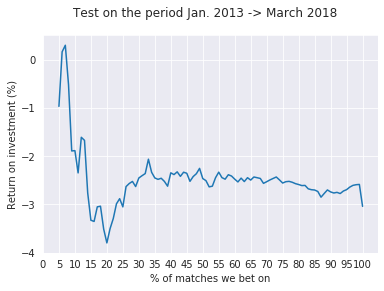

In [118]:
## Plot of ROI according to the % of matches we bet on
plotProfits(conf,"Test on the period Jan. 2013 -> March 2018")

In [105]:
## We bet only on 35% of the matches
confconf=conf.iloc[:int(0.35*len(conf)),:]

Text(0, 0.5, 'For each section, number of matches we bet on')

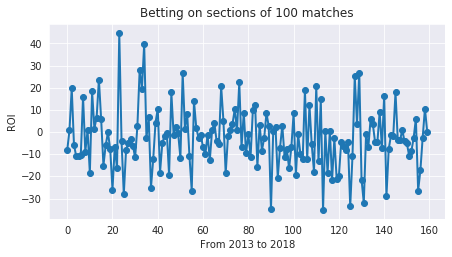

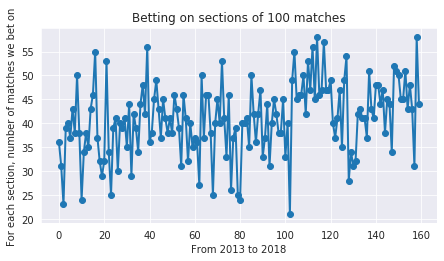

In [107]:
matches_delta=117
profits,lens=profitsAlongTime(confconf,matches_delta)

fig=plt.figure(figsize=(5.5,3))
ax = fig.add_axes([0,0,1,0.9])  
ax.plot(profits,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 100 matches")
ax.set_xlabel("From 2013 to 2018")
ax.set_ylabel("ROI")

fig=plt.figure(figsize=(5.5,3))
ax = fig.add_axes([0,0,1,0.9])  
ax.plot(lens,linewidth=2,marker="o")
plt.suptitle("Betting on sections of 100 matches")
ax.set_xlabel("From 2013 to 2018")
ax.set_ylabel("For each section, number of matches we bet on")

In [109]:
conf

,match,PSW,win0,confidence0,date
0,29250,1.33,0,2.381414,2019-01-14
1,22042,1.31,0,2.140069,2016-04-07
2,14819,3.13,1,2.131751,2013-06-14
3,22118,1.41,0,2.051760,2016-04-16
4,20769,1.52,0,2.009410,2015-09-06
...,...,...,...,...,...
18838,31936,NaN,1,NaN,2020-02-04
18839,31950,NaN,1,NaN,2020-02-04
18840,32036,NaN,0,NaN,2020-02-11
18841,32037,NaN,0,NaN,2020-02-11


In [2]:
use, ful = assessStrategyGlobal(start,10400,duration_val_matches,duration_test_matches,
                     xgb_params,nb_players,nb_tournaments,features,data,"1")

NameError: name 'assessStrategyGlobal' is not defined

In [1]:
ful

NameError: name 'ful' is not defined

In [ ]:
conf=vibratingAssessStrategyGlobal(start,10400,duration_val_matches,
                                   duration_test_matches,xgb_params,nb_players,nb_tournaments,features,data)
    